# Example of Logistic regression

## Predict student admission based on exams result

Data is taken from [Andrew Ng's CS229 course on Machine Learning at Stanford](http://cs229.stanford.edu/).

In [1]:
import pandas as pd

In [4]:
data = pd.read_csv("datasets/ex2data1.txt", header=None, 
                   names=['Exam1', 'Exam2', 'Admitted'])  

In [5]:
data.head()

,Exam1,Exam2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Historical data from previous students: each student has two exams scores associated and the final admission result (1=yes, 0= no).  
Let's plot the points in a chart (green means admitted, red not admitted).

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
colours = ['red' if i==0 else 'green' for i in data.Admitted]

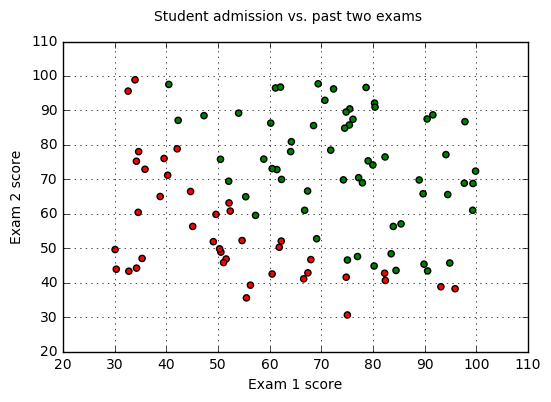

In [9]:
fig,ax = plt.subplots()
ax.scatter(data.Exam1, data.Exam2, c=colours)
ax.grid(True)
ax.set_xlabel("Exam 1 score")
ax.set_ylabel("Exam 2 score")
fig.suptitle("Student admission vs. past two exams")

If the score of the first or the second exam was too low, it might be not enough to be admitted. You need a good balance.
Let's try to quantify it.

## The sigmoid function

Logistic regression uses a special function to model how the probability of the event "Admitted" P(y=1) is affected by our variables (the exams score).  
This function is the sigmoid function:

$$ g(z) = \frac{1}{1 + e^{-z}}$$

In [10]:
import numpy as np

In [11]:
def sigmoid(z):  
    """
    Compute the sigmoid function of each input value.
    It uses numpy to leverage the vectorised format.

    Argument:
        z:   matrix, vector or scalar (float)

    Returns:
        matrix, vector or float
    """
    
    return 1 / (1 + np.exp(-z))


Let's plot it:

In [12]:
x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)

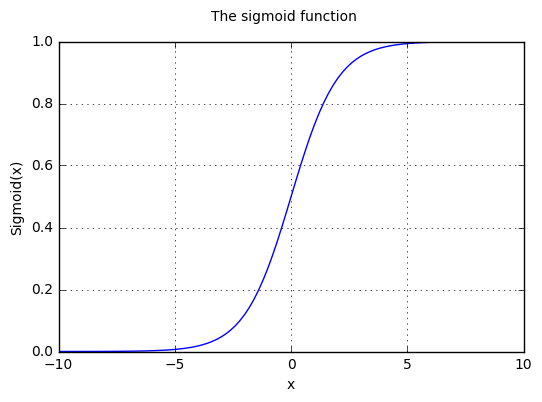

In [13]:
fig,ax = plt.subplots()
ax.plot(x,sig)
ax.grid(True)
ax.set_xlabel("x")
ax.set_ylabel("Sigmoid(x)")
fig.suptitle("The sigmoid function")

Unit tests:

In [14]:
sigmoid(1)

0.7310585786300049

In [15]:
sigmoid(np.array([2,3]))

array([ 0.88079708,  0.95257413])

## Logistic Response function: cost and gradient

This is the logistic function to model our admission:  
  
$P(y=1) = \frac{1}{1 + e^{-(\beta_{0} + \beta_{1} \cdot x_{1} + ... + \beta_{n} \cdot x_{n}) }} $

where y is the admission result (0 or 1) and x are the exams scores. 
We have in our example x1 and x2 (two exams).  
Our next step is to find the correct beta parameters for the model.  
And we will do it by using our historical data as a training set, like we did for the linear regression, using a gradient descent algorithm (see [the blog post](https://mashimo.wordpress.com/) for details).  

The algorithm will find the optimal beta parameters that **minimise** the cost. We need to define a function to calculate the cost and the gradient:

In [16]:
def getCostGradient(beta, X, y):
    """
    Compute the cost of a particular choice of beta as the
    parameter for logistic regression and the gradient of the cost
    w.r.t. to the parameters.
    Returns cost and gradient
    
    Arguments:
        beta:  parameters, list
        X: input data points, array
        y  : output data points, array

    Returns:
        float - the cost
        array of float - the gradient (same dimension as beta parameters)
    """
      # Initialize some useful values
    y = np.squeeze(y)  # this is to avoid broadcasting when element-wise multiply
    m = len(y) # number of training examples
    grad = np.zeros(beta.shape) # grad should have the same dimensions as beta
    
      # Compute the partial derivatives and set grad to the partial
      #               derivatives of the cost w.r.t. each parameter in theta
      
    h = sigmoid(np.dot(X, beta))
    
       # J cost function
    y0 = y * np.log(h)
    y1 = (1 - y) * np.log(1 - h)
    cost = -np.sum(y0 + y1) / m
    
       # gradient
    error = h - y
    grad = np.dot(error, X) / m

    return (cost, grad)


Unit test:

In [17]:
getCostGradient(np.array([-1,0.2]),  np.array([[1,34], [1,35]]), np.array([0,1]))

(2.9027493330342948, array([  0.49725448,  16.90541602]))

## Split data into X (training data) and y (target variable)

In [18]:
cols = data.shape[1]
cols

3

In [19]:
# add the intercept
data.insert(0, 'Ones', 1)

In [20]:
X = data.iloc[:,0:cols]  # the first columns but the last are X
X = np.array(X.values)

In [21]:
y = data.iloc[:,cols:cols+1] # last column is the y
y = np.array(y.values)  

In [22]:
initialBeta = np.zeros(cols)  # could be random also

what is the cost given these initial beta parameters?

In [23]:
getCostGradient(initialBeta, X, y)

(0.69314718055994529, array([ -0.1       , -12.00921659, -11.26284221]))

Initial cost is 0.69

## Fit the beta parameters

To find the optimal beta parameters we use a highly tuned function (*minimize*) from the package *SciPy*.  
We need to provide the cost and the gradient function, the input data and which method to use (we use the classic Newton). The argument Jac=True tells that cost and gradient are together in the same function. 

In [24]:
import scipy.optimize as opt  

In [25]:
result = opt.minimize(fun = getCostGradient,  x0 = initialBeta, args = (X, y),
                          method = 'Newton-CG',jac = True) 

In [26]:
result.message

'Optimization terminated successfully.'

In [27]:
optimalBeta = result.x

and here we have our final beta parameters:

In [28]:
optimalBeta

array([-25.1685201 ,   0.20628907,   0.20152988])

$$P(y=1) = \frac{1}{1 + e^{25.17 - 0.21 \cdot x_{1} - 0.20 \cdot x_{2} }} $$

## Plot the decision boundary

We can use these beta parameters to plot the decision boundary on the training data.

We only need two points to plot a line, so we choose two endpoints: the min and the max among the X training data (we add a small margin of 2 to have a longer line in the plot, looks better).

In [33]:
plot_x = np.array([min(X[:,2])-2,  max(X[:,2])+2])
plot_x

array([  28.60326323,  100.86943574])

The boundary lies where the P(y=1) = P(y=0) = 0.5  
which means that beta * X shall be zero

In [35]:
plot_y = (-1./optimalBeta[2]) * (optimalBeta[1] * plot_x + optimalBeta[0])
plot_y

array([ 95.60854757,  21.63578984])

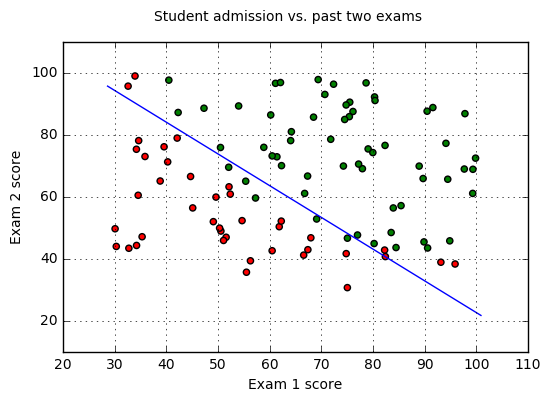

In [37]:
fig,ax = plt.subplots()
ax.scatter(data.Exam1, data.Exam2, c=colours)
ax.plot(plot_x, plot_y)
ax.grid(True)
ax.set_xlabel("Exam 1 score")
ax.set_ylabel("Exam 2 score")
fig.suptitle("Student admission vs. past two exams")

The blue line is our decision boundary: when your exams score lie below the line then probably (that is the prediction) you will not be admitted to University. If they lie above, probably you will.

As you can see, the boundary is not predicting perfectly on the training historical data. It's a model. Not perfect but useful.
What we can do is to measure its accuracy.

## Accuracy

In [38]:
def predict(beta, X):  
    probabilities = sigmoid(np.dot(X, beta))
    return [1 if x >= 0.5 else 0 for x in probabilities]

In [39]:
predictions = predict(optimalBeta, X)

In [41]:
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) 
           else 0 for (a, b) in zip(predictions, y)]  
accuracy = (sum(map(int, correct)) % len(correct))  
print ('accuracy = {0}%'.format(accuracy)  )

accuracy = 89%


Just for fun, let's say that my scores are 40 in the first exam and 78 in the second one:

In [42]:
myExams = np.array([1., 40., 78.])

In [43]:
sigmoid(np.dot(myExams, optimalBeta))

0.23189774249785097

Uh oh, looks's like my probability to be admitted at University is only 23% ...